In [ ]:
import torchvision.transforms as transforms
import torchvision
import pandas as pd

import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var
from collections import defaultdict

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt



In [ ]:
################## 1. Download checkpoints and build models
MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====
assert MODEL_DEPTH in {16, 20, 24, 30}

# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'vae' not in globals() or 'var' not in globals():
    vae, var = build_vae_var(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        num_classes=1000, depth=MODEL_DEPTH, shared_aln=False,
    )

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')

prepare finished.


In [73]:
for name, module in var.named_modules():
    # Only print leaf modules (no children)
    if len(list(module.children())) == 0:
        if hasattr(module, 'weight') and hasattr(module.weight, 'shape'):
            print(f"{name}: {module.__class__.__name__} - weight shape {tuple(module.weight.shape)}")
        elif hasattr(module, 'bias') and hasattr(module.bias, 'shape'):
            print(f"{name}: {module.__class__.__name__} - bias shape {tuple(module.bias.shape)}")
        else:
            print(f"{name}: {module.__class__.__name__}")

word_embed: Linear - weight shape (1024, 32)
class_emb: Embedding - weight shape (1001, 1024)
lvl_embed: Embedding - weight shape (10, 1024)
shared_ada_lin: Identity
blocks.0.drop_path: Identity
blocks.0.attn.mat_qkv: Linear - weight shape (3072, 1024)
blocks.0.attn.proj: Linear - weight shape (1024, 1024)
blocks.0.attn.proj_drop: Identity
blocks.0.ffn.fc1: Linear - weight shape (4096, 1024)
blocks.0.ffn.act: GELU
blocks.0.ffn.fc2: Linear - weight shape (1024, 4096)
blocks.0.ffn.drop: Identity
blocks.0.ln_wo_grad: LayerNorm
blocks.0.ada_lin.0: SiLU
blocks.0.ada_lin.1: Linear - weight shape (6144, 1024)
blocks.1.drop_path: DropPath
blocks.1.attn.mat_qkv: Linear - weight shape (3072, 1024)
blocks.1.attn.proj: Linear - weight shape (1024, 1024)
blocks.1.attn.proj_drop: Identity
blocks.1.ffn.fc1: Linear - weight shape (4096, 1024)
blocks.1.ffn.act: GELU
blocks.1.ffn.fc2: Linear - weight shape (1024, 4096)
blocks.1.ffn.drop: Identity
blocks.1.ln_wo_grad: LayerNorm
blocks.1.ada_lin.0: SiLU
b

In [ ]:
# Main hooks used in experiments
def extract_var_activations(var_model, input_tokens, target_layers=None):
    """
    Extract activations from VAR model layers during forward pass
    
    Args:
        var_model: The loaded VAR model
        input_tokens: Input tokens for the model
        target_layers: List of layer names to extract (if None, extracts all FFN layers)
    
    Returns:
        Dictionary of layer_name -> activation tensor
    """
    activations = {}
    hooks = []
    
    if target_layers is None:
        target_layers = []
        for name, module in var_model.named_modules():
            target_layers.append(name)
            #if not name == "head":
            #    target_layers.append(name)
            #if 'ffn.fc1' in name or 'ffn.fc2' in name or name == 'head':
            #    target_layers.append(name)
    
    def make_hook(layer_name):
        def hook_fn(module, input, output):
            # Store activation, handling different output shapes
            if isinstance(output, torch.Tensor):
                # We .detach() in both cases to avoid keeping the computation graph and to prevent memory leaks
                if len(output.shape) == 3:  # [batch, sequence, features]
                    # Average across sequence dimension for transformers
                    # Needed because some layers return [batch, sequence, features]
                    activations[layer_name] = output.mean(dim=1).detach()
                else:
                    activations[layer_name] = output.detach()
            else:
                # Handle tuple outputs (some layers return multiple values)
                activations[layer_name] = output[0].detach()
        return hook_fn
    
    # Register hooks
    for layer_name in target_layers:
        try:
            layer = dict(var_model.named_modules())[layer_name]
            hook = layer.register_forward_hook(make_hook(layer_name))
            hooks.append(hook)
        except KeyError:
            print(f"Warning: Layer {layer_name} not found")
    
    # Perform forward pass
    try:
        with torch.no_grad():
            # Give dummy label for forward pass
            # This is necessary for some models that expect a label input
            # Here we use a dummy tensor of shape [1] as the label
            _ = var_model(torch.tensor([1,]), input_tokens)
    finally:
        # Clean up hooks
        for hook in hooks:
            hook.remove()
    
    return activations


# Not used in experiments, but useful for debugging or analysis
def extract_all_linear_activations(var_model, input_tokens):
    """
    Extract activations from all Linear (fully connected) layers in the VAR model.

    Args:
        var_model: The loaded VAR model
        input_tokens: Input tokens for the model

    Returns:
        Dictionary of layer_name -> activation tensor
    """
    activations = {}
    hooks = []

    # Find all Linear layers
    for name, module in var_model.named_modules():
        if isinstance(module, torch.nn.Linear):
            def make_hook(layer_name):
                def hook_fn(module, input, output):
                    if isinstance(output, torch.Tensor):
                        if len(output.shape) == 3:
                            activations[layer_name] = output.mean(dim=1).detach()
                        else:
                            activations[layer_name] = output.detach()
                    else:
                        activations[layer_name] = output[0].detach()
                return hook_fn
            hook = module.register_forward_hook(make_hook(name))
            hooks.append(hook)

    try:
        with torch.no_grad():
            _ = var_model(torch.tensor([1,]), input_tokens)
    finally:
        for hook in hooks:
            hook.remove()

    return activations

In [ ]:
# This creates the dataloader for our imagenet subset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create dataset
dataset = datasets.ImageFolder(
    root='./data/SomeClasses/',
    transform=transform
)

# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1
)

In [ ]:
# These are the augmentations we averaged over as described in the UnitMeme paper
# Some augmentations were not used which were included in the UnitMem repo because they caused issues
s = 1
color_jitter = transforms.ColorJitter(
        0.9 * s, 0.9 * s, 0.9 * s, 0.1 * s)
flip = transforms.RandomHorizontalFlip()
Aug = transforms.Compose(
    [
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([color_jitter], p=0.9),
    transforms.RandomGrayscale(p=0.1)
    ])

In [ ]:
# In this cell we iterate over 200 images from the dataloader, apply 10 random augmentations, and collect the results.
# The results are stored in `all_means`, which contains the mean activations for each layer across all augmentations for each image.
nsamples = 200
all_means = []
for i, image in enumerate(dataloader): 
    print(i)
    if i >= nsamples:
        break
    image = image[0]
    print(image.shape)
    # Display the image before augmentation
    import matplotlib.pyplot as plt
    img_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.imshow(img_np)
    plt.title(f"Original Image {i}")
    plt.axis('off')
    plt.show()

    image = image.to(device)
    this_imgs_activations = []
    for _ in range(10):  # Iterate over different random augmentations
        image = Aug(image)  # Apply random augmentation
        with torch.no_grad():
            vae_out = vae.img_to_idxBl(image)
            var_in = var.vae_quant_proxy[0].idxBl_to_var_input(vae_out)    
        activations = extract_var_activations(var, var_in)
        this_imgs_activations.append(activations)
    # Compute the mean activation across all augmentations for each layer in all_activations
    layer_means = {}
    if this_imgs_activations:
        # Get all layer names from the first activation dict
        layer_names = this_imgs_activations[0].keys()
        for lname in layer_names:
            # Stack tensors for this layer across all augmentations
            # This basically creates a tensor of shape [num_augmentations, features] over which we can then compute the mean
            stacked = torch.stack([a[lname] for a in this_imgs_activations], dim=0)
            # Compute mean across augmentations (dim=0)
            layer_means[lname] = stacked.mean(dim=0)
            
    # This is the final mean that is saved for each image
    # It contains the mean activations for each layer across all augmentations for this image
    all_means.append(layer_means)

In [ ]:
#For each layer, stack all mean activations across images and compute the maximum and argmax per unit
max_per_unit_all_layers = {}
argmax_per_unit_all_layers = {}

layer_names = all_means[0].keys()
for lname in layer_names:
    # Stack all mean activations for this layer across images
    stacked_means = torch.stack([mean[lname] for mean in all_means], dim=0)
    # Compute the maximum and argmax for each unit across all images (dim=0)
    stacked_means = stacked_means.abs()
    max_per_unit_all_layers[lname] = stacked_means.max(dim=0).values
    argmax_per_unit_all_layers[lname] = stacked_means.argmax(dim=0)
    print(f"Layer: {lname}")
    print(f"Maximum per unit: {max_per_unit_all_layers[lname]}")
    print(f"Argmax per unit: {argmax_per_unit_all_layers[lname]}")

In [ ]:
'''
#
layer_argmax_freq = {}

for (layer, unit), argmax_val in zip(top100_units, top100_argmax):
    if layer not in layer_argmax_freq:
        layer_argmax_freq[layer] = []
    layer_argmax_freq[layer].append(argmax_val)

# Build a DataFrame for each layer showing the most frequent argmax values
for layer, argmax_list in layer_argmax_freq.items():
    vals, counts = np.unique(argmax_list, return_counts=True)
    df = pd.DataFrame({'Argmax Value': vals, 'Count': counts})
    df = df.sort_values('Count', ascending=False).reset_index(drop=True)
    print(f"Layer: {layer}")
    display(df.head(5))  # Show top 5 most frequent argmax values per layer
'''

In [ ]:
# For each layer, compute the mean activation across all images except the one at argmax for each unit
mean_minus_max_per_unit_all_layers = {}

layer_names = all_means[0].keys()
n_imgs = len(all_means)
for lname in layer_names:
    # Stack all mean activations for this layer across images: shape [n_imgs, 1, n_units]
    stacked_means = torch.stack([mean[lname] for mean in all_means], dim=0) # bit unnecessary, but keeps the code consistent
    # Find argmax index for each unit
    stacked_means = stacked_means.abs()     # To take the absolute value unitmem metric
    argmax_idx = stacked_means.argmax(dim=0)  # shape [1, n_units]
    # For each unit, exclude the image at argmax and compute mean over the rest
    means = []
    for unit in range(stacked_means.shape[2]):
        # Get indices of all images except the one at argmax for this unit
        mask = torch.ones(n_imgs, dtype=torch.bool)
        mask[argmax_idx[0, unit]] = False
        # Compute mean over the remaining images for this unit
        mean_val = stacked_means[mask, 0, unit].mean()
        means.append(mean_val)
    mean_minus_max_per_unit_all_layers[lname] = torch.stack(means)
    print(f"Layer: {lname}, \mu-max per unit shape: {mean_minus_max_per_unit_all_layers[lname]}")

In [ ]:
# Compute the difference between max_per_unit_all_layers and mean_minus_max_per_unit_all_layers for each layer
diff_max_minus_mean_all_layers = {}

for lname in max_per_unit_all_layers.keys():
    diff_max_minus_mean_all_layers[lname] = max_per_unit_all_layers[lname] - mean_minus_max_per_unit_all_layers[lname]
    print(f"Layer: {lname}, Difference shape: {diff_max_minus_mean_all_layers[lname].shape}")
    print(diff_max_minus_mean_all_layers[lname])

In [ ]:
# Compute the normalized difference: (max - mean) / (max + mean) for each layer
normalized_diff_all_layers = {}

for lname in diff_max_minus_mean_all_layers.keys():
    max_vals = max_per_unit_all_layers[lname]
    mean_vals = mean_minus_max_per_unit_all_layers[lname]
    denom = max_vals + mean_vals
    # Avoid division by zero
    normalized_diff = diff_max_minus_mean_all_layers[lname] / (denom + 1e-8)
    normalized_diff_all_layers[lname] = normalized_diff
    print(f"Layer: {lname}, Normalized difference shape: {normalized_diff.shape}")
    print(normalized_diff)

In [ ]:
'''
# Flatten all normalized differences across all layers into a single tensor
all_norm_diffs = []
unit_layer_map = []

for lname, norm_diff in normalized_diff_all_layers.items():
    # norm_diff shape: [1, n_units]
    n_units = norm_diff.shape[1]
    for unit_idx in range(n_units):
        all_norm_diffs.append(norm_diff[0, unit_idx].item())
        unit_layer_map.append((lname, unit_idx))

all_norm_diffs = torch.tensor(all_norm_diffs)

# Compute the number of top units (10%)
topk_percent = 0.1
k = max(1, int(len(all_norm_diffs) * topk_percent))

# Get the indices of the top 10% highest values
topk_vals, topk_indices = torch.topk(all_norm_diffs, k)

# Map indices back to (layer, unit) pairs
topk_units_overall = [unit_layer_map[idx] for idx in topk_indices.tolist()]

print(f"Top {k} units overall (layer, unit): {topk_units_overall}")
'''

In [ ]:
# Choose the 10% highest activating units overall (across all layers)
all_units = []
unit_layer_map = []
topk_percent = 0.1
for lname, norm_diff in normalized_diff_all_layers.items():
    # norm_diff shape: [1, n_units]
    n_units = norm_diff.shape[1]
    for unit_idx in range(n_units):
        all_units.append(norm_diff[0, unit_idx].item())
        unit_layer_map.append((lname, unit_idx))

all_units = torch.tensor(all_units)
k = max(1, int(len(all_units) * topk_percent))
topk_vals, topk_indices = torch.topk(all_units, k)

# Map back to (layer, unit) pairs
# Exclude units from the 'head' layer
topk_units_overall = [unit_layer_map[idx] for idx in topk_indices.tolist() if unit_layer_map[idx][0] != 'head']
print(f"Top {k} units overall (layer, unit) excluding 'head': {topk_units_overall}")

In [ ]:
'''
# Sum activations for each layer in topk_layer_names using topk_vals (all top units, not just top 100)
layer_activation_sums_all = {}

for lname, val in zip(topk_layer_names, topk_vals):
    if lname not in layer_activation_sums_all:
        layer_activation_sums_all[lname] = 0.0
    layer_activation_sums_all[lname] += float(val)

# Convert to DataFrame
topk_layer_sum_df = pd.DataFrame(
    list(layer_activation_sums_all.items()), columns=['Layer', 'Activation Sum']
).sort_values('Activation Sum', ascending=False).reset_index(drop=True)

display(topk_layer_sum_df)
'''

,Layer,Activation Sum
0,,874.049136
1,blocks.15.ffn.act,857.257347
2,blocks.15.ffn.fc1,742.686553
3,blocks.1.ffn.act,411.798700
4,blocks.15.ffn.drop,334.003220
...,...,...
228,blocks.12.ada_lin,14.206367
229,head_nm.ada_lin,10.481958
230,head_nm.ada_lin.1,10.481945
231,blocks.11.ada_lin.1,8.364927


In [ ]:
# Really unnecessarily complicated ordering. 
'''
# Create a DataFrame showing the distribution of top-k units across layers, ordered by layer position

# Extract just the layer names from topk_units_overall (ignore unit index)
topk_layer_names = [layer for layer, unit in topk_units_overall]

# Count occurrences of each layer in the top-k units
layer_counts = pd.Series(topk_layer_names).value_counts().rename_axis('Layer').reset_index(name='TopK_Count')

# To order by layer position, extract the numeric index from the layer name (e.g., 'blocks.3.ffn.fc1' -> 3)
def layer_sort_key(layer_name):
    if layer_name.startswith('blocks.'):
        # Extract the block number
        parts = layer_name.split('.')
        try:
            block_num = int(parts[1])
        except Exception:
            block_num = -1
        # Optionally, sort by sublayer type as well
        sublayer_priority = {'ffn.fc1': 0, 'ffn.fc2': 1, 'attn.proj': 2, 'ada_lin.1': 3}
        sublayer = '.'.join(parts[2:]) if len(parts) > 2 else ''
        sublayer_idx = sublayer_priority.get(sublayer, 99)
        return (block_num, sublayer_idx)
    elif layer_name == 'word_embed':
        return (-2, 0)
    elif layer_name == 'head':
        return (999, 0)
    else:
        return (998, 0)

layer_counts['sort_key'] = layer_counts['Layer'].apply(layer_sort_key)
layer_counts = layer_counts.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)

# Show the full DataFrame without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(layer_counts)
'''

In [114]:
# Show the 10 neurons with the highest activations among the top 10% highest activating neurons
top10_indices = torch.topk(topk_vals, 100).indices
for idx in top10_indices:
    layer, unit = topk_units_overall[idx]
    mem_value = topk_vals[idx].item()
    print(f"Layer: {layer}, Unit: {unit}, mem value: {mem_value:.4f}")

Layer: blocks.1.ffn.act, Unit: 431, mem value: 0.9777
Layer: blocks.1.ffn.act, Unit: 2094, mem value: 0.9273
Layer: blocks.1.ffn.act, Unit: 2458, mem value: 0.9235
Layer: blocks.3.ffn.act, Unit: 3354, mem value: 0.9164
Layer: blocks.2.ffn.act, Unit: 2945, mem value: 0.9135
Layer: blocks.1.ffn.act, Unit: 2400, mem value: 0.9107
Layer: blocks.3.ffn.act, Unit: 3028, mem value: 0.8910
Layer: blocks.0.ffn.act, Unit: 2016, mem value: 0.8885
Layer: blocks.4.ffn.act, Unit: 2595, mem value: 0.8884
Layer: blocks.3.ffn.act, Unit: 2602, mem value: 0.8845
Layer: blocks.3.ffn.act, Unit: 1881, mem value: 0.8834
Layer: blocks.1.ffn.act, Unit: 3785, mem value: 0.8781
Layer: blocks.0.ffn.act, Unit: 3003, mem value: 0.8773
Layer: blocks.1.ffn.act, Unit: 3763, mem value: 0.8766
Layer: blocks.0.ffn.act, Unit: 223, mem value: 0.8707
Layer: blocks.3.ffn.act, Unit: 3899, mem value: 0.8699
Layer: blocks.3.ffn.act, Unit: 1630, mem value: 0.8696
Layer: blocks.1.ffn.act, Unit: 1256, mem value: 0.8688
Layer: block

In [ ]:
# Show the 10 neurons with the lowest activations among the top 10% highest activating neurons
top10_indices = torch.topk(topk_vals, 100, largest=False).indices
for idx in top10_indices:
    unit = topk_indices[idx]
    layer = unit_layer_map[idx]
    mem_value = topk_vals[idx].item()
    print(f"Layer: {layer}, Unit: {unit}, mem value: {mem_value:.4f}")

Layer: ('blocks.1.attn.proj_drop', 920), Unit: 214265, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 919), Unit: 33965, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 918), Unit: 54141, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 917), Unit: 425872, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 916), Unit: 268217, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 915), Unit: 464552, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 914), Unit: 503337, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 913), Unit: 507433, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 912), Unit: 210191, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 911), Unit: 60218, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 909), Unit: 504079, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 910), Unit: 508175, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 908), Unit: 151655, mem value: 0.5274
Layer: ('blocks.1.attn.proj_drop', 907), Unit: 455284,

In [ ]:
# Doing some analysis on the top-k units

# Extract block names from topk_layer_names (e.g., 'blocks.3.ffn.act' -> 'blocks.3')
def extract_block_name(layer_name):
    if layer_name.startswith('blocks.'):
        parts = layer_name.split('.')
        return f"{parts[0]}.{parts[1]}"
    else:
        return layer_name  # For non-block layers like 'word_embed', etc.

topk_block_names = [extract_block_name(name) for name in topk_layer_names]

# Count occurrences of each block in the top-k units
block_counts = pd.Series(topk_block_names).value_counts().rename_axis('Block').reset_index(name='TopK_Count')

# Sort blocks numerically if possible
def block_sort_key(block_name):
    if block_name.startswith('blocks.'):
        try:
            return int(block_name.split('.')[1])
        except Exception:
            return 999
    else:
        return 1000  # Non-blocks at the end

block_counts['sort_key'] = block_counts['Block'].apply(block_sort_key)
block_counts = block_counts.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)

display(block_counts)

,Block,TopK_Count
0,blocks.0,2904
1,blocks.1,3203
2,blocks.2,3162
3,blocks.3,3055
4,blocks.4,2953
5,blocks.5,3150
6,blocks.6,2745
7,blocks.7,2800
8,blocks.8,2382
9,blocks.9,2383


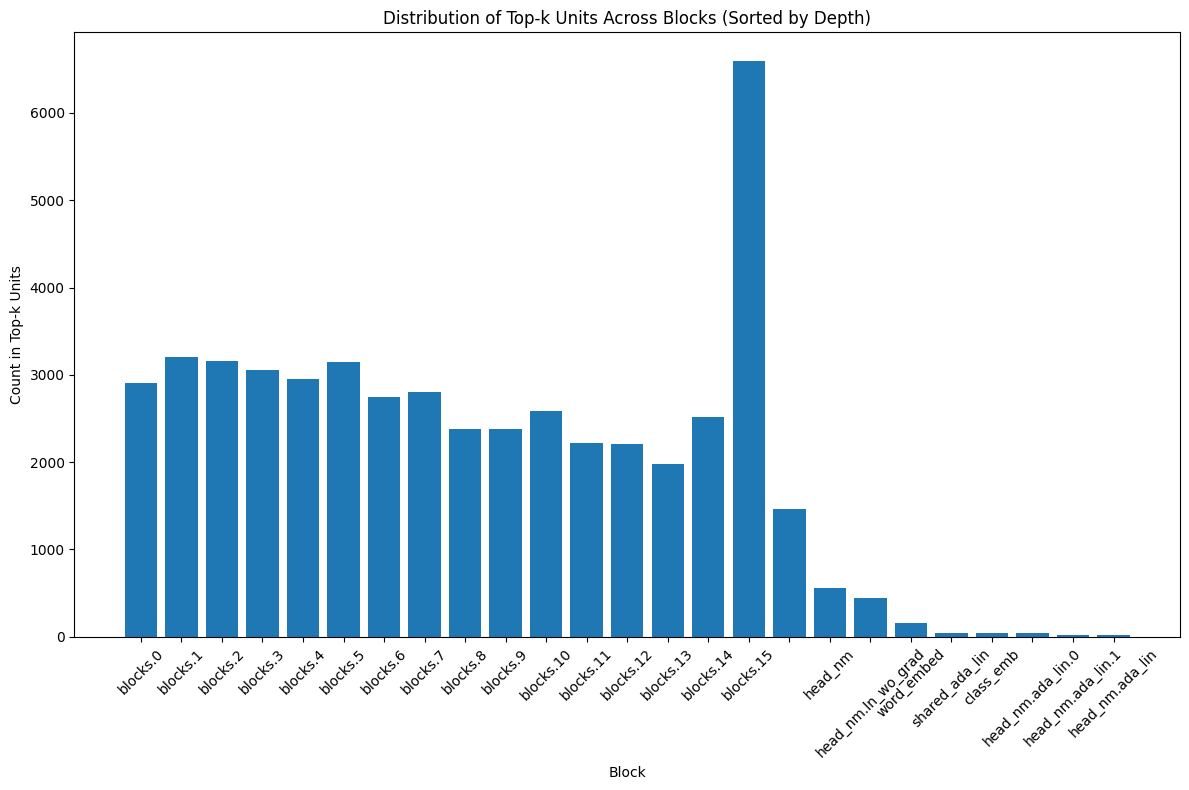

In [ ]:


# Count occurrences of each block in the topk_block_names list
block_counts = pd.Series(topk_block_names).value_counts().reset_index()
block_counts.columns = ['Block', 'Count']

# Extract block number for sorting
def block_sort_key(block_name):
    if block_name.startswith('blocks.'):
        try:
            return int(block_name.split('.')[1])
        except Exception:
            return 999
    else:
        return 1000  # Non-blocks at the end

block_counts['sort_key'] = block_counts['Block'].apply(block_sort_key)
block_counts = block_counts.sort_values('sort_key').reset_index(drop=True)

# Plot bar chart
plt.figure(figsize=(12, 8))
plt.bar(block_counts['Block'], block_counts['Count'])
plt.xlabel('Block')
plt.ylabel('Count in Top-k Units')
plt.title('Distribution of Top-k Units Across Blocks (Sorted by Depth)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

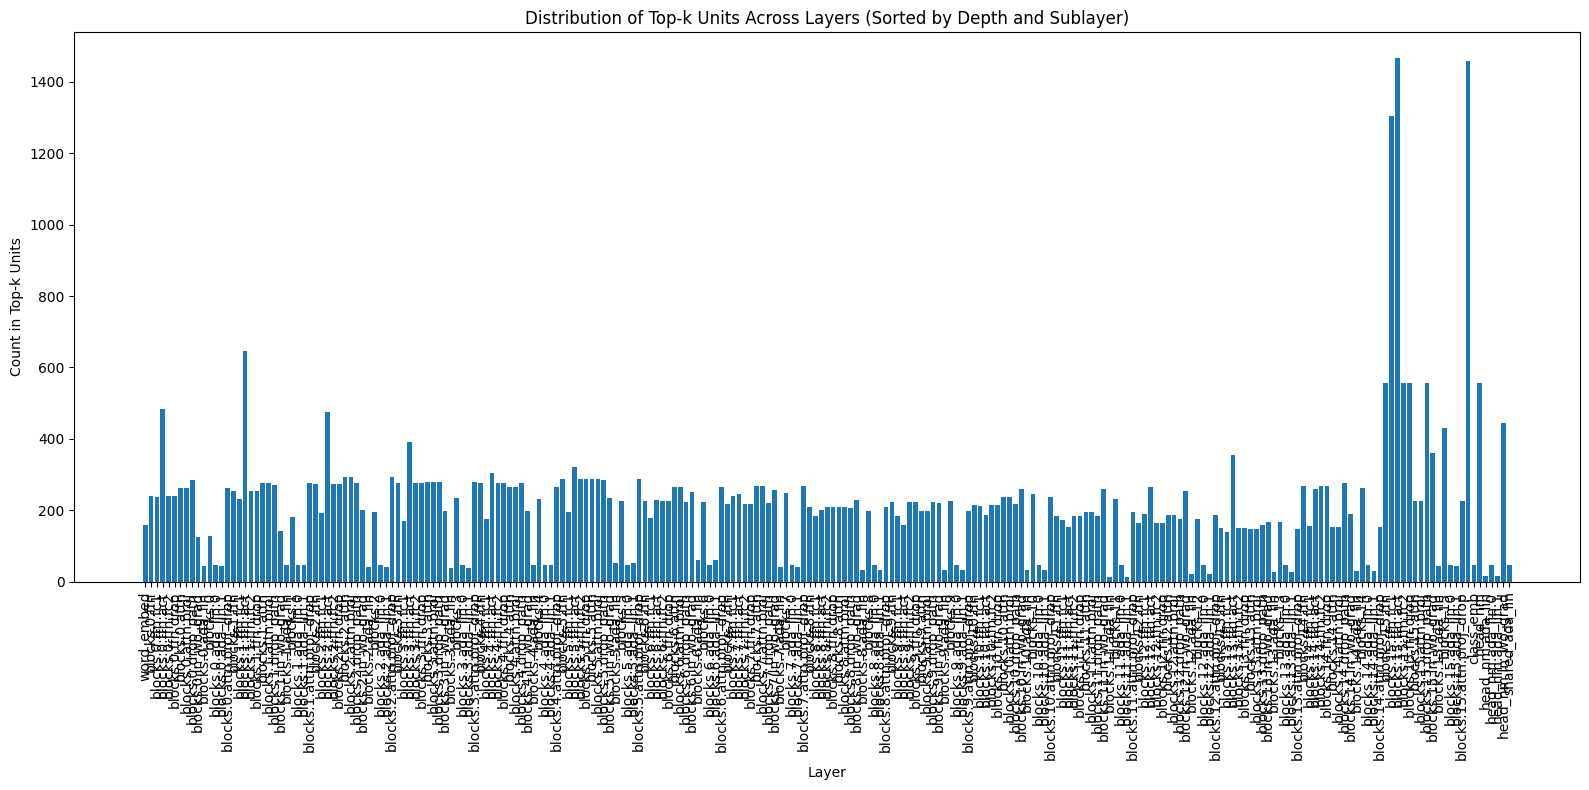

In [ ]:


# Count occurrences of each layer in the topk_layer_names list
layer_counts = pd.Series(topk_layer_names).value_counts().reset_index()
layer_counts.columns = ['Layer', 'Count']

# Extract block and sublayer number for sorting
def layer_sort_key(layer_name):
    if layer_name.startswith('blocks.'):
        parts = layer_name.split('.')
        try:
            block_num = int(parts[1])
        except Exception:
            block_num = 999
        # Try to sort sublayers: ffn, attn, drop_path, etc.
        sublayer_priority = {
            'ffn': 0, 'ffn.fc1': 1, 'ffn.act': 2, 'ffn.fc2': 3, 'ffn.drop': 4,
            'attn': 10, 'attn.proj': 11, 'drop_path': 20, 'ln_wo_grad': 30, 'ada_lin': 40
        }
        sublayer = '.'.join(parts[2:]) if len(parts) > 2 else ''
        sublayer_idx = sublayer_priority.get(sublayer, 99)
        return (block_num, sublayer_idx, layer_name)
    elif layer_name == 'word_embed':
        return (-2, 0, layer_name)
    elif layer_name == 'head':
        return (999, 0, layer_name)
    else:
        return (998, 0, layer_name)

layer_counts['sort_key'] = layer_counts['Layer'].apply(layer_sort_key)
layer_counts = layer_counts.sort_values('sort_key').reset_index(drop=True)

# Plot bar chart
plt.figure(figsize=(16, 8))
plt.bar(layer_counts['Layer'], layer_counts['Count'])
plt.xlabel('Layer')
plt.ylabel('Count in Top-k Units')
plt.title('Distribution of Top-k Units Across Layers (Sorted by Depth and Sublayer)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

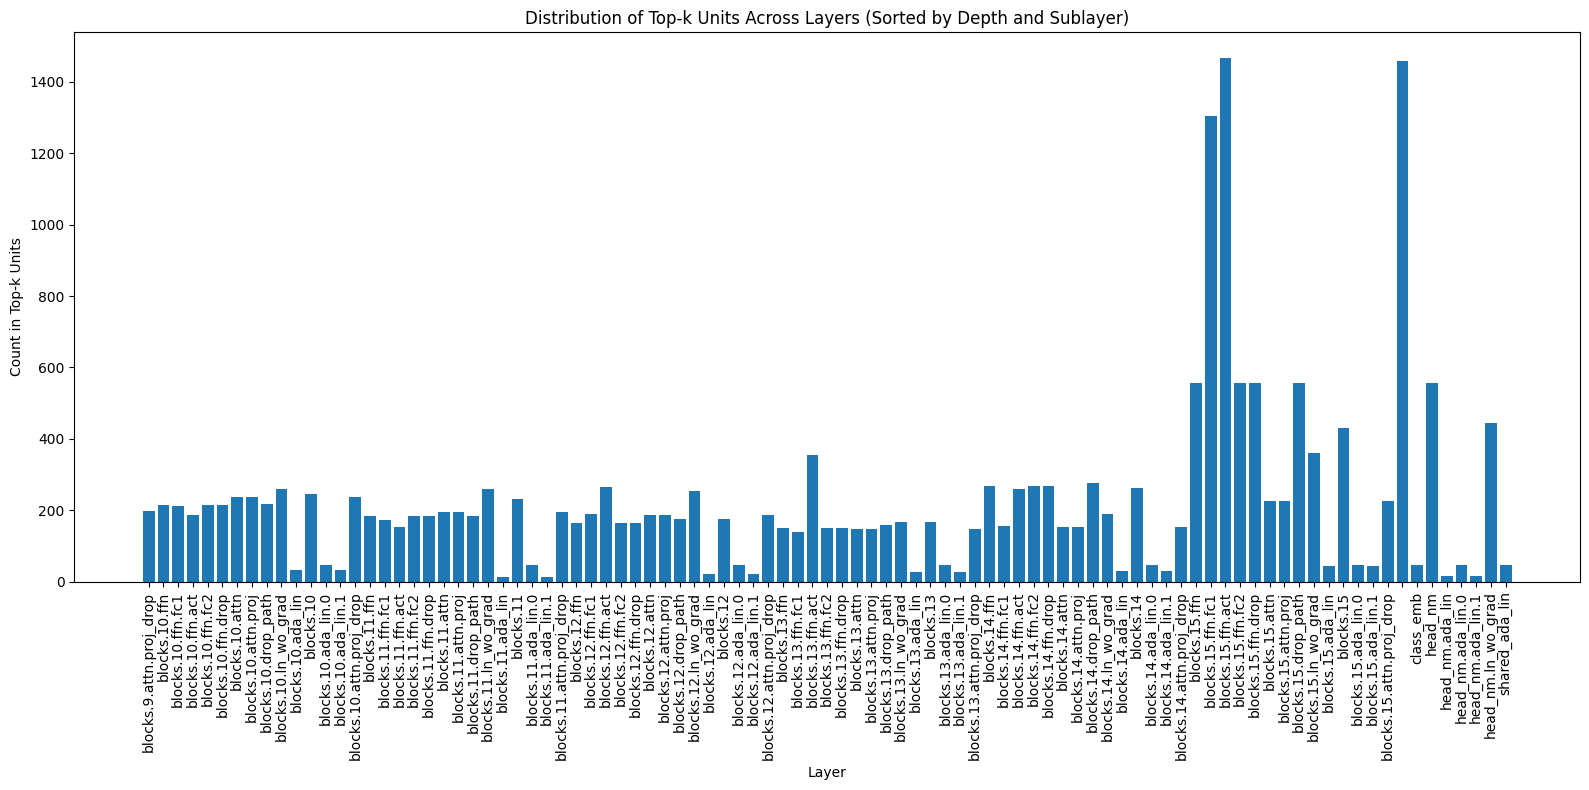

In [ ]:


# Count occurrences of each layer in the topk_layer_names list
layer_counts = pd.Series(topk_layer_names).value_counts().reset_index()
layer_counts.columns = ['Layer', 'Count']

# Extract block and sublayer number for sorting
def layer_sort_key(layer_name):
    if layer_name.startswith('blocks.'):
        parts = layer_name.split('.')
        try:
            block_num = int(parts[1])
        except Exception:
            block_num = 999
        # Try to sort sublayers: ffn, attn, drop_path, etc.
        sublayer_priority = {
            'ffn': 0, 'ffn.fc1': 1, 'ffn.act': 2, 'ffn.fc2': 3, 'ffn.drop': 4,
            'attn': 10, 'attn.proj': 11, 'drop_path': 20, 'ln_wo_grad': 30, 'ada_lin': 40
        }
        sublayer = '.'.join(parts[2:]) if len(parts) > 2 else ''
        sublayer_idx = sublayer_priority.get(sublayer, 99)
        return (block_num, sublayer_idx, layer_name)
    elif layer_name == 'word_embed':
        return (-2, 0, layer_name)
    elif layer_name == 'head':
        return (999, 0, layer_name)
    else:
        return (998, 0, layer_name)

layer_counts['sort_key'] = layer_counts['Layer'].apply(layer_sort_key)
layer_counts = layer_counts.sort_values('sort_key').reset_index(drop=True)
layer_counts = layer_counts[140:]
# Plot bar chart
plt.figure(figsize=(16, 8))
plt.bar(layer_counts['Layer'], layer_counts['Count'])
plt.xlabel('Layer')
plt.ylabel('Count in Top-k Units')
plt.title('Distribution of Top-k Units Across Layers (Sorted by Depth and Sublayer)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

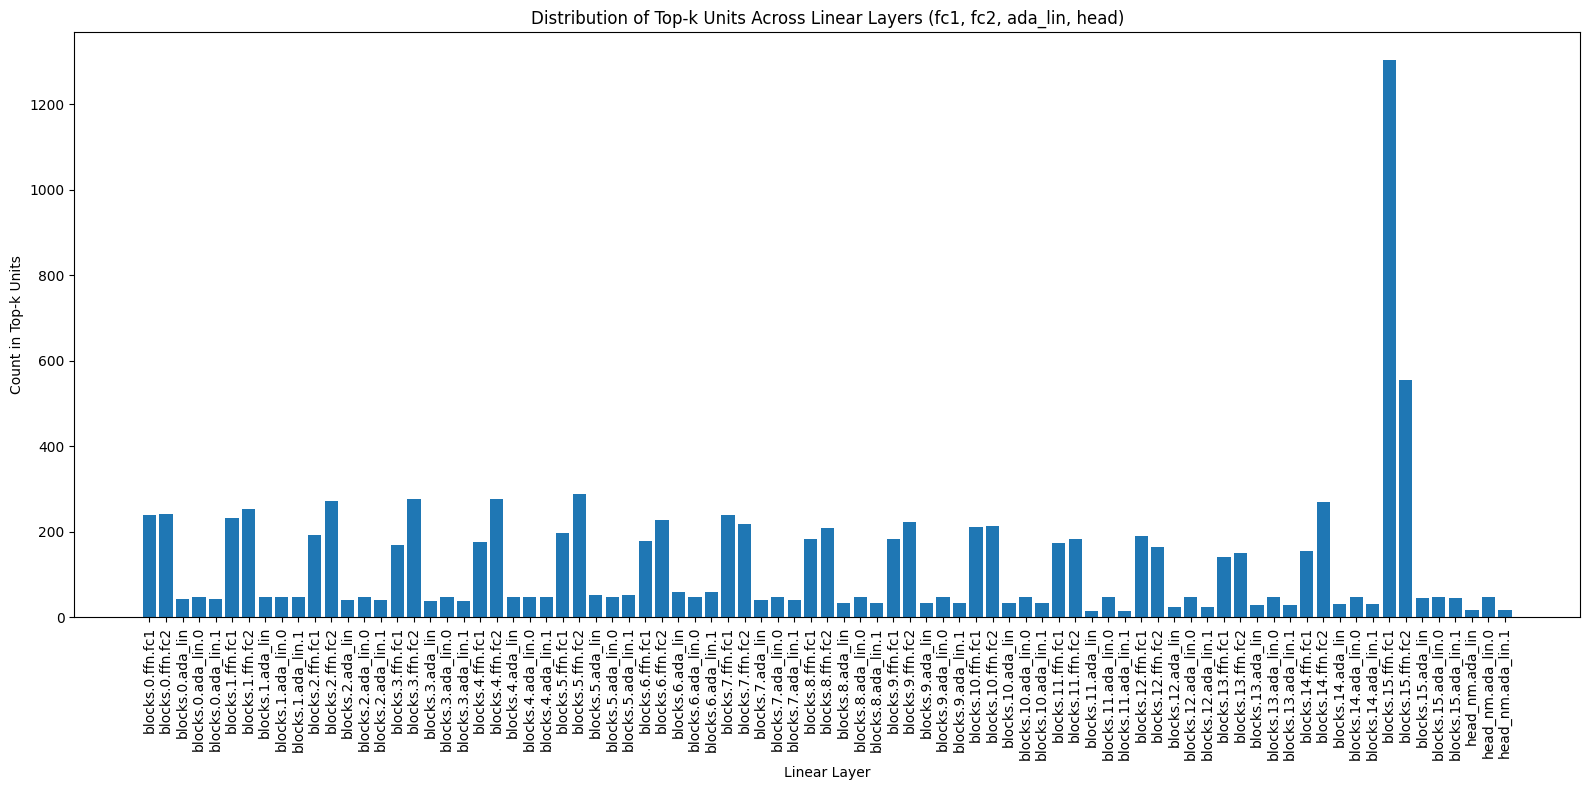

In [ ]:

# Only keep layers that are linear (fc1, fc2, ada_lin, head, etc.)
def is_linear_layer(layer_name):
    return (
        '.fc1' in layer_name or
        '.fc2' in layer_name or
        '.ada_lin' in layer_name or
        layer_name == 'head'
    )

linear_layer_names = [name for name in topk_layer_names if is_linear_layer(name)]

# Count occurrences of each linear layer in the top-k units
linear_layer_counts = pd.Series(linear_layer_names).value_counts().reset_index()
linear_layer_counts.columns = ['Layer', 'Count']

# Sorting: extract block and sublayer number for sorting
def linear_layer_sort_key(layer_name):
    if layer_name.startswith('blocks.'):
        parts = layer_name.split('.')
        try:
            block_num = int(parts[1])
        except Exception:
            block_num = 999
        # Sort fc1, fc2, ada_lin
        if 'fc1' in layer_name:
            sublayer_idx = 0
        elif 'fc2' in layer_name:
            sublayer_idx = 1
        elif 'ada_lin' in layer_name:
            sublayer_idx = 2
        else:
            sublayer_idx = 99
        return (block_num, sublayer_idx, layer_name)
    elif layer_name == 'head':
        return (999, 0, layer_name)
    else:
        return (998, 0, layer_name)

linear_layer_counts['sort_key'] = linear_layer_counts['Layer'].apply(linear_layer_sort_key)
linear_layer_counts = linear_layer_counts.sort_values('sort_key').reset_index(drop=True)

# Plot bar chart
plt.figure(figsize=(16, 8))
plt.bar(linear_layer_counts['Layer'], linear_layer_counts['Count'])
plt.xlabel('Linear Layer')
plt.ylabel('Count in Top-k Units')
plt.title('Distribution of Top-k Units Across Linear Layers (fc1, fc2, ada_lin, head)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


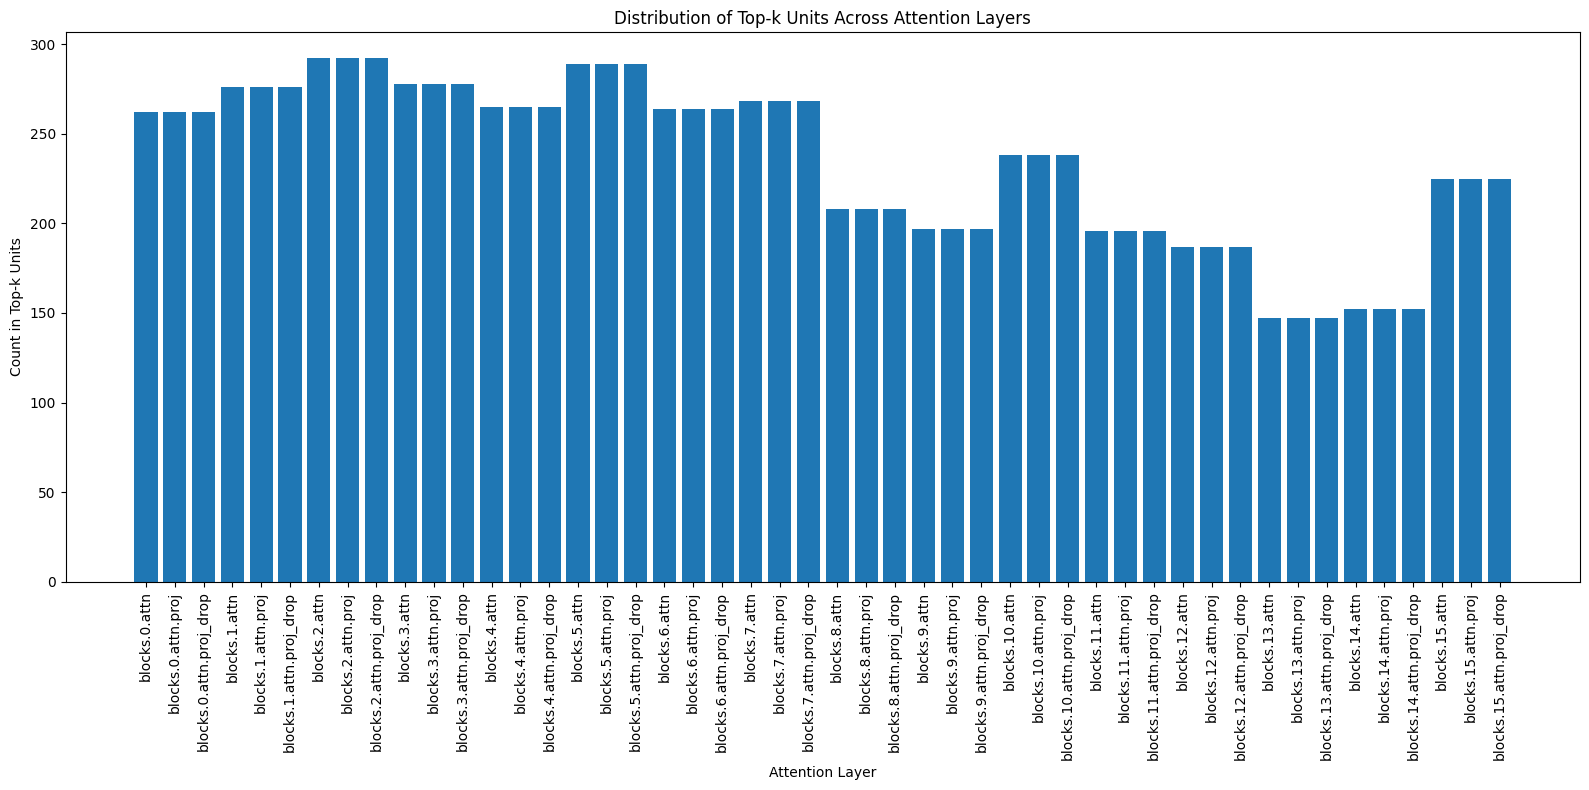

In [ ]:


# Only keep layers that are attention layers (e.g., contain '.attn' or '.attn.proj')
def is_attn_layer(layer_name):
    return '.attn' in layer_name

attn_layer_names = [name for name in topk_layer_names if is_attn_layer(name)]

# Count occurrences of each attention layer in the top-k units
attn_layer_counts = pd.Series(attn_layer_names).value_counts().reset_index()
attn_layer_counts.columns = ['Layer', 'Count']

# Sorting: extract block and sublayer number for sorting
def attn_layer_sort_key(layer_name):
    if layer_name.startswith('blocks.'):
        parts = layer_name.split('.')
        try:
            block_num = int(parts[1])
        except Exception:
            block_num = 999
        # Sort attn, attn.proj, etc.
        if 'attn.proj' in layer_name:
            sublayer_idx = 1
        elif 'attn' in layer_name:
            sublayer_idx = 0
        else:
            sublayer_idx = 99
        return (block_num, sublayer_idx, layer_name)
    else:
        return (998, 0, layer_name)

attn_layer_counts['sort_key'] = attn_layer_counts['Layer'].apply(attn_layer_sort_key)
attn_layer_counts = attn_layer_counts.sort_values('sort_key').reset_index(drop=True)

# Plot bar chart
plt.figure(figsize=(16, 8))
plt.bar(attn_layer_counts['Layer'], attn_layer_counts['Count'])
plt.xlabel('Attention Layer')
plt.ylabel('Count in Top-k Units')
plt.title('Distribution of Top-k Units Across Attention Layers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:

# Extract argmax values for the topk_units_overall
topk_argmax = []
for lname, unit_idx in topk_units_overall:
    # Find the corresponding argmax tensor for this layer
    if lname in argmax_per_unit_all_layers:
        argmax_tensor = argmax_per_unit_all_layers[lname]
        # Handle possible shape [1, n_units]
        if argmax_tensor.dim() == 2:
            topk_argmax.append(argmax_tensor[0, unit_idx].item())
        else:
            topk_argmax.append(argmax_tensor[unit_idx].item())
    else:
        # If layer not found, skip
        continue

# Count occurrences of each argmax value
values, counts = np.unique(topk_argmax, return_counts=True)
topk_argmax_freq_df = pd.DataFrame({'Argmax Value': values, 'Count': counts})
topk_argmax_freq_df = topk_argmax_freq_df.sort_values('Count', ascending=False).reset_index(drop=True)

display(topk_argmax_freq_df.head(20))

,Argmax Value,Count
0,92,6590
1,52,3184
2,86,2202
3,143,1930
4,47,1765
5,176,1671
6,142,1610
7,35,1527
8,129,1184
9,183,941
